In [1]:
#importing libraries
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import time
import itertools
from datetime import datetime
from sklearn.naive_bayes import GaussianNB
from matplotlib.gridspec import GridSpec
from sklearn.impute import SimpleImputer, MissingIndicator
from sklearn.preprocessing import OneHotEncoder, StandardScaler, RobustScaler
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.model_selection import train_test_split, cross_val_score, cross_val_predict, GridSearchCV, RandomizedSearchCV, StratifiedShuffleSplit, ShuffleSplit, StratifiedKFold, learning_curve, KFold
from sklearn.linear_model import LogisticRegression, SGDClassifier
from sklearn.tree import DecisionTreeClassifier, ExtraTreeClassifier
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier, VotingClassifier, BaggingClassifier, GradientBoostingClassifier, ExtraTreesClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.svm import LinearSVC, NuSVC, SVC
from sklearn.neighbors import KNeighborsClassifier, NearestCentroid
import xgboost as xgb
import lightgbm as lgb
import catboost as cb
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier
from catboost import CatBoostClassifier
from sklearn.feature_selection import SelectFromModel
from sklearn.metrics import accuracy_score, precision_score, recall_score, precision_recall_curve, precision_recall_fscore_support, f1_score, confusion_matrix, roc_curve, roc_auc_score, classification_report
import warnings
warnings.filterwarnings("ignore", category=DeprecationWarning)
warnings.simplefilter("ignore")
pd.set_option('display.max_columns', 100)
%matplotlib inline
random = 40

In [2]:
# defining visualizaition functions
def format_spines(ax, right_border=True):
    
    ax.spines['bottom'].set_color('#666666')
    ax.spines['left'].set_color('#666666')
    ax.spines['top'].set_visible(False)
    if right_border:
        ax.spines['right'].set_color('#FFFFFF')
    else:
        ax.spines['right'].set_color('#FFFFFF')
    ax.patch.set_facecolor('#FFFFFF')
    

def count_plot(feature, df, colors='Blues_d', hue=False, ax=None, title=''):
    
    ncount = len(df)
    if hue != False:
        ax = sns.countplot(x=feature, data=df, palette=colors, hue=hue, ax=ax)
    else:
        ax = sns.countplot(x=feature, data=df, palette=colors, ax=ax)
        
    format_spines(ax)

    for p in ax.patches:
        x=p.get_bbox().get_points()[:,0]
        y=p.get_bbox().get_points()[1,1]
        ax.annotate('{:.1f}%'.format(100.*y/ncount), (x.mean(), y), 
                ha='center', va='bottom') # set the alignment of the text

    if not hue:
        ax.set_title(df[feature].describe().name + ' Analysis', size=13, pad=15)
    else:
        ax.set_title(df[feature].describe().name + ' Analysis by ' + hue, size=13, pad=15)  
    if title != '':
        ax.set_title(title)       
    plt.tight_layout()
    
    
def bar_plot(x, y, df, colors='Blues_d', hue=False, ax=None, value=False, title=''):

    try:
        ncount = sum(df[y])
    except:
        ncount = sum(df[x])
        
    if hue != False:
        ax = sns.barplot(x=x, y=y, data=df, palette=colors, hue=hue, ax=ax, ci=None)
    else:
        ax = sns.barplot(x=x, y=y, data=df, palette=colors, ax=ax, ci=None)

    format_spines(ax)

    for p in ax.patches:
        xp=p.get_bbox().get_points()[:,0]
        yp=p.get_bbox().get_points()[1,1]
        if value:
            ax.annotate('{:.2f}k'.format(yp/1000), (xp.mean(), yp), 
                    ha='center', va='bottom') # set the alignment of the text
        else:
            ax.annotate('{:.1f}%'.format(100.*yp/ncount), (xp.mean(), yp), 
                    ha='center', va='bottom') # set the alignment of the text
    if not hue:
        ax.set_title(df[x].describe().name + ' Analysis', size=12, pad=15)
    else:
        ax.set_title(df[x].describe().name + ' Analysis by ' + hue, size=12, pad=15)
    if title != '':
        ax.set_title(title)  
    plt.tight_layout()

def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function set up and plot a Confusion Matrix
    """
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title, fontsize=14)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes)
    plt.yticks(tick_marks, classes)
    
    # Format plot
    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 1.2
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j]),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    
def create_dataset():
    """
    This functions creates a dataframe to keep performance analysis
    """
    attributes = ['acc', 'prec', 'rec', 'f1', 'auc', 'total_time']
    model_performance = pd.DataFrame({})
    for col in attributes:
        model_performance[col] = []
    return model_performance

def model_analysis(classifiers, X, y, df_performance, cv=5, train=True):
    """
    This function brings up a full model evaluation and saves it in a DataFrame object.
    """
    for key, model in classifiers.items():
        t0 = time.time()
        
        # Accuracy, precision, recall and f1_score on training set using cv
        if train:
            acc = cross_val_score(model, X, y, cv=cv, scoring='accuracy').mean()
            prec = cross_val_score(model, X, y, cv=cv, scoring='precision').mean()
            rec = cross_val_score(model, X, y, cv=cv, scoring='recall').mean()
            f1 = cross_val_score(model, X, y, cv=cv, scoring='f1').mean()
        else:
            y_pred = model.predict(X)
            acc = accuracy_score(y, y_pred)
            prec = precision_score(y, y_pred)
            rec = recall_score(y, y_pred)
            f1 = f1_score(y, y_pred)
        
        # AUC score
        try:
            y_scores = cross_val_predict(model, X, y, cv=5, 
                                     method='decision_function')
        except:
            # Trees don't have decision_function but predict_proba
            y_probas = cross_val_predict(model, X, y, cv=5, 
                                         method='predict_proba')
            y_scores_tree = y_probas[:, 1]
            y_scores = y_scores_tree
        auc = roc_auc_score(y, y_scores)
        
        t1 = time.time()
        delta_time = t1-t0
        model_name = model.__class__.__name__
        
        # Saving on dataframe
        performances = {}
        performances['acc'] = round(acc, 4)
        performances['prec'] = round(prec, 4)
        performances['rec'] = round(rec, 4)
        performances['f1'] = round(f1, 4)
        performances['auc'] = round(auc, 4)
        performances['total_time'] = round(delta_time, 3)
        
        df_performance = df_performance.append(performances, ignore_index=True)
    df_performance.index = classifiers.keys()
    
    return df_performance

def model_confusion_matrix(classifiers, X, y, cmap=plt.cm.Blues):
    """
    This function computes predictions for all model and plots a confusion matrix
    for each one.
    """
    i = 1
    plt.figure(figsize=(21, 8))
    sns.set(style='white', palette='muted', color_codes=True)
    labels = ['Positive', 'Negative']
    
    # Ploting confusion matrix
    for key, model in classifiers.items(): 
        y_pred = model.predict(X)
        model_cf_mx = confusion_matrix(y, y_pred)

        # Plotando matriz
        model_name = model.__class__.__name__
        plt.subplot(2, 5, i)
        plot_confusion_matrix(model_cf_mx, labels, title=model_name + '\nConfusion Matrix', cmap=cmap)
        i += 1

    plt.tight_layout()
    plt.show()
    
def plot_roc_curve(fpr, tpr, y, y_scores, auc, label=None):
    """
    This function plots the ROC curve of a model
    """   
    # Showing data
    sns.set(style='white', palette='muted', color_codes=True)
    plt.plot(fpr, tpr, linewidth=2, label=f'{label}, auc={auc:.3f}')
    plt.plot([0, 1], [0, 1], 'k--')
    plt.axis([-0.02, 1.02, -0.02, 1.02])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title(f'ROC Curve', size=14)
    plt.annotate('Minimum ROC Score of 50% \n (This is the minimum score to get)', 
                 xy=(0.5, 0.5), xytext=(0.6, 0.4),
                 arrowprops=dict(facecolor='#6E726D', shrink=0.05),
                )
    plt.legend()
    
def plot_precision_vs_recall(precisions, recalls, label=None, color='b'):
    """
    This function plots precision versus recall curve.
    """
    sns.set(style='white', palette='muted', color_codes=True)
    if label=='LogisticRegression':
        plt.plot(recalls, precisions, 'r-', linewidth=2, label=label)
    else:
        plt.plot(recalls, precisions, color=color, linewidth=2, label=label)
    plt.title('Precision versus Recall', fontsize=14)
    plt.xlabel('Recall')
    plt.ylabel('Precision')
    plt.axis([0, 1, 0, 1])
    plt.legend()
    
def plot_precision_recall_vs_threshold(precisions, recalls, thresholds):
    """
    This function plots precision x recall among different thresholds
    """
    plt.plot(thresholds, precisions[:-1], 'b--', label='Precision')
    plt.plot(thresholds, recalls[:-1], 'g-', label='Recall')
    plt.xlabel('Threshold')
    plt.title('Precision versus Recall - Thresholds', size=14)
    plt.legend(loc='best')
    plt.ylim([0, 1])
    
def plot_learning_curve(trained_models, X, y, ylim=None, cv=5, n_jobs=1, 
                        train_sizes=np.linspace(.1, 1.0, 10)):
    fig, axs = plt.subplots(nrows=5, ncols=2, figsize=(14, 20))
    if ylim is not None:
        plt.ylim(*ylim)
    i = 0
    j = 0
    for key, model in trained_models.items():
        train_sizes, train_scores, test_scores = learning_curve(model, X, y, cv=cv, n_jobs=n_jobs, 
                                                                train_sizes=train_sizes)
        train_scores_mean = np.mean(train_scores, axis=1)
        train_scores_std = np.std(train_scores, axis=1)
        test_scores_mean = np.mean(test_scores, axis=1)
        test_scores_std = np.std(test_scores, axis=1)
        axs[i, j].fill_between(train_sizes, train_scores_mean - train_scores_std,
                               train_scores_mean + train_scores_std, alpha=0.1, color='blue')
        axs[i, j].fill_between(train_sizes, test_scores_mean - test_scores_std,
                               test_scores_mean + test_scores_std, alpha=0.1, color='crimson')
        axs[i, j].plot(train_sizes, train_scores_mean, 'o-', color="navy",
                       label="Training score")
        axs[i, j].plot(train_sizes, test_scores_mean, 'o-', color="red",
                       label="Cross-Validation score")
        axs[i, j].set_title(f'{key} Learning Curve', size=14)
        axs[i, j].set_xlabel('Training size (m)')
        axs[i, j].set_ylabel('Score')
        axs[i, j].grid(True)
        axs[i, j].legend(loc='best')
        j += 1
        if j == 2:
            i += 1
            j = 0

In [3]:
# loading train and test data
train = pd.read_csv('Desktop/DS ToolKit/DataSet/train_technidus_clf.csv')
test = pd.read_csv('Desktop/DS ToolKit/DataSet/test_technidus_clf.csv')

In [4]:
# checking for columns in train df not present in test df 
for col in train.columns:
    if col not in test.columns:
        print(col)

In [5]:
# combining train and test data
df = pd.concat([train, test], keys=['x', 'y'])

In [6]:
# displaying first three rows of dataset
df.head(3)

CustomerID Title  FirstName MiddleName LastName Suffix  \
x 0     14540.0   NaN      Randy        NaN      Lin    NaN   
  1     18054.0   NaN       Jake        NaN     Zeng    NaN   
  2     16955.0   NaN  Nathaniel        NaN  Bradley    NaN   

              AddressLine1 AddressLine2       City StateProvinceName  \
x 0            8848 Auburn          NaN     London           England   
  1         4058 First Ave          NaN  Cliffside  British Columbia   
  2  3679 Diablo View Road          NaN  Metchosin  British Columbia   

    CountryRegionName PostalCode          PhoneNumber  BirthDate   Education  \
x 0    United Kingdom    W1Y 3RA  1 (11) 500 555-0138  4/18/1958  Bachelors    
  1            Canada    V8Y 1L1         987-555-0118  10/6/1960  Bachelors    
  2            Canada         V9         145-555-0167  8/18/1969  Bachelors    

         Occupation Gender MaritalStatus  HomeOwnerFlag  NumberCarsOwned  \
x 0          Manual      M             M            1.0              0.0   
  1    Professional      M             S            0.0              1.0   
  2  Skilled Manual      M             M            1.0              0.0   

     NumberChildrenAtHome  TotalChildren  YearlyIncome  AveMonthSpend  \
x 0                   0.0            1.0       35455.0           70.0   
  1                   0.0            0.0       43980.0           69.0   
  2                   2.0            2.0       57713.0          102.0   

     BikeBuyer  
x 0        1.0  
  1        0.0  
  2        0.0

In [7]:
# displaying dataset information
df.info()

<class 'pandas.core.frame.DataFrame'>
MultiIndex: 11014 entries, (x, 0) to (y, 3327)
Data columns (total 25 columns):
CustomerID              11013 non-null float64
Title                   62 non-null object
FirstName               11013 non-null object
MiddleName              6353 non-null object
LastName                11013 non-null object
Suffix                  2 non-null object
AddressLine1            11013 non-null object
AddressLine2            183 non-null object
City                    11013 non-null object
StateProvinceName       11013 non-null object
CountryRegionName       11013 non-null object
PostalCode              11013 non-null object
PhoneNumber             11013 non-null object
BirthDate               11013 non-null object
Education               11013 non-null object
Occupation              11013 non-null object
Gender                  11013 non-null object
MaritalStatus           11013 non-null object
HomeOwnerFlag           11013 non-null float64
NumberCarsOwned 

In [8]:
# displaying summary staticstics of columns
df.describe(include='all')

,CustomerID,Title,FirstName,MiddleName,LastName,Suffix,AddressLine1,AddressLine2,City,StateProvinceName,CountryRegionName,PostalCode,PhoneNumber,BirthDate,Education,Occupation,Gender,MaritalStatus,HomeOwnerFlag,NumberCarsOwned,NumberChildrenAtHome,TotalChildren,YearlyIncome,AveMonthSpend,BikeBuyer
count,11013.000000,62,11013,6353,11013,2,11013,183,11013,11013,11013,11013,11013,11013,11013,11013,11013,11013,11013.000000,11013.000000,11013.000000,11013.000000,11013.000000,11013.000000,7686.000000
unique,NaN,3,631,40,321,1,8805,111,255,47,6,306,5399,6355,5,5,2,2,NaN,NaN,NaN,NaN,NaN,NaN,NaN
top,NaN,Mr.,Richard,L,Diaz,Jr.,Attaché de Presse,Verkaufsabteilung,London,California,United States,97005,1 (11) 500 555-0118,3/13/1972,Bachelors,Professional,M,M,NaN,NaN,NaN,NaN,NaN,NaN,NaN
freq,NaN,34,63,769,122,2,14,20,265,2637,4610,124,134,9,3318,3584,5790,5545,NaN,NaN,NaN,NaN,NaN,NaN,NaN
mean,20207.841823,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.676292,1.566422,1.227368,2.146282,82243.639335,76.382730,0.992454
std,5363.369456,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.467911,1.182520,1.649023,1.724151,40523.633521,29.385713,43.501344
min,11000.000000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.000000,0.000000,0.000000,0.000000,10063.000000,22.000000,0.000000
25%,15526.000000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.000000,1.000000,0.000000,1.000000,50596.000000,53.000000,0.000000
50%,20187.000000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.000000,2.000000,0.000000,2.000000,81942.000000,72.000000,0.000000
75%,24897.000000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.000000,2.000000,2.000000,4.000000,109516.000000,89.000000,1.000000


The above table shows the summary statistics of each column in the dataset from this table we can observe such statistics as the mean, mode, standard deviation, mininum, maximum, 25th and 75th percentile values, also we can see how many unique values are in each column and the number of rows, from the above table we can spot out columns with missing values, variable skewness, constant colums, columns that wont be of use and also categorical columns.

In [9]:
# spliting df to train and test dataset
train = df.loc['x']
test = df.loc['y']

In [10]:
# displaying missing value counts and corresponding percentage against total observations
missing_values = train.isnull().sum().sort_values(ascending = False)
percentage = (train.isnull().sum()/train.isnull().count()*100).sort_values(ascending = False)
pd.concat([missing_values, percentage], axis=1, keys=['Values', 'Percentage']).transpose()

,Suffix,Title,AddressLine2,MiddleName,PhoneNumber,PostalCode,FirstName,LastName,AddressLine1,City,StateProvinceName,CountryRegionName,CustomerID,AveMonthSpend,BirthDate,Education,Occupation,Gender,MaritalStatus,HomeOwnerFlag,NumberCarsOwned,NumberChildrenAtHome,TotalChildren,YearlyIncome,BikeBuyer
Values,7685.000000,7645.000000,7551.00000,3229.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,0.0
Percentage,99.986989,99.466563,98.24356,42.011449,0.013011,0.013011,0.013011,0.013011,0.013011,0.013011,0.013011,0.013011,0.013011,0.013011,0.013011,0.013011,0.013011,0.013011,0.013011,0.013011,0.013011,0.013011,0.013011,0.013011,0.0


OBSERVATIONS

1. The Original dataset contains 7686 rows and 25 columns of which 17 were type object, 7 float(64) and 1(int64).
2. Several columns were noted to have missing values with the majority of important features having less than 0.01% missing values

In [11]:
# dropping non-important feature set
df = df.drop(["CustomerID", "Title", "FirstName", "MiddleName", "LastName", "Suffix", "AddressLine1", "AddressLine2", "PhoneNumber"], axis=1)

In [12]:
# spliting df to train and test dataset
train = df.loc['x']
test = df.loc['y']

In [13]:
# dropping missing values as it occured in just one row
train.dropna(inplace=True)
train.isnull().values.any()

False

In [14]:
# combining train and test data
df = pd.concat([train, test], keys=['x', 'y'])

In [15]:
# rounding up floats
float_columns = ['HomeOwnerFlag', 'NumberCarsOwned', 'NumberChildrenAtHome', 'TotalChildren', 'YearlyIncome', 'AveMonthSpend']
for col in float_columns:
    df[col] = df[col].apply(np.ceil).astype('int64')

In [16]:
# converting birthdate to age
df['BirthDate'] = pd.to_datetime(df.BirthDate)
now = pd.to_datetime('now')
df['BirthDate'] = (now.year - df['BirthDate'].dt.year) - ((now.month - df['BirthDate'].dt.month) < 0)
# engineering new columns Ageband and Monthlyincome
df['AgeBand']=df['BirthDate'].apply(lambda x: 'Young' if x<=40 else ('Middleaged' if x>=41 and x<=70 else 'Old'))
df['MonthlyIncome']=df['YearlyIncome'].apply(lambda x: x/12).apply(np.ceil).astype('int64')

1) I dropped some of the columns that were of no analytical value to us, such columns as the title, names, suffix, address, and phone numbers majorly had a large number of missing values and would contribute little to nothing during analysis hence they were dropped.

2) I observed that the dataset had equal amounts of missing values across several columns hence I had to drop them because the numbers were consistent and amounted to less than 0.14%.

3) Given that majority of the floats had no decimal values, they were converted integer(64). That of the total number of children at home and the likes that had decimal values were rounded up cos realistically it is impossible to have 1.4 children.

4) The birth date was first converted to datetime and was converted to age for ease of use and better insight.

I also engineered two new columns AgeBand which seeks to draw insights from the age columns grading them into the categories Young(<40 yrs), Middleaged(41-70 yrs) and old(>70 yrs), using this column we can be able to tell various age bands and their BikeBuying behaviours. From the YearlyIncome column, a new column MonthlyIncome was binned, this will be used in place of YearlyIncome as it follows with the AverageMonthlySpend column and shares similar quartile ranges.

In [17]:
# spliting df to train and test dataset
train = df.loc['x']
test = df.loc['y']

# Univariate Analysis 

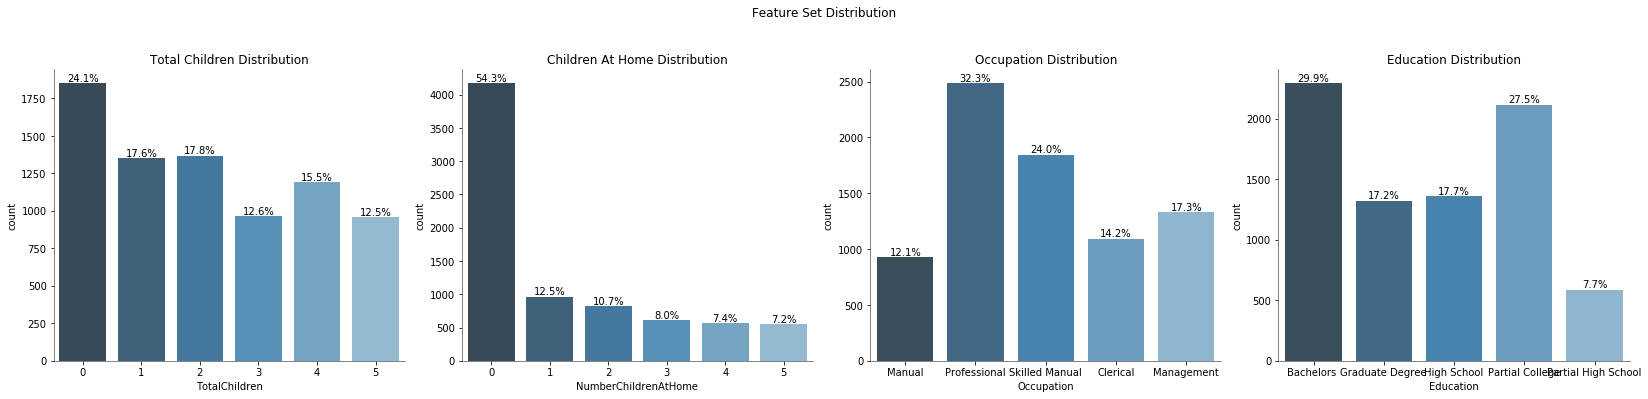

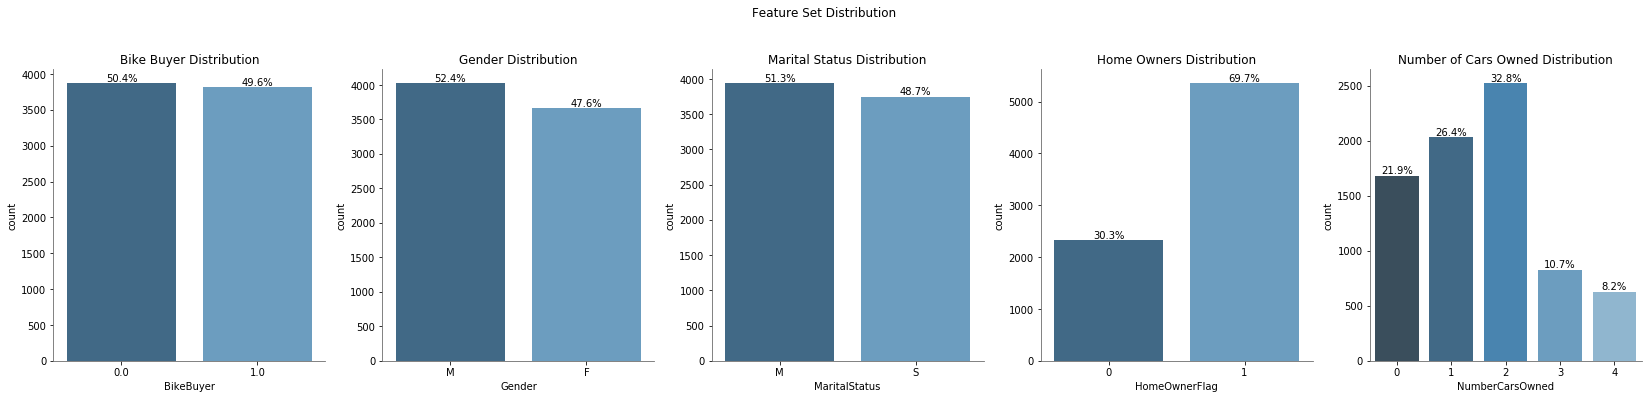

In [18]:
# displaying total orders the disribution of each of the dependent(categorical) columns
fig, axs = plt.subplots(1, 4, figsize=(23, 5))
count_plot(feature='TotalChildren', df=train, ax=axs[0], title='Total Children Distribution')
count_plot(feature='NumberChildrenAtHome', df=train, ax=axs[1], title='Children At Home Distribution')
count_plot(feature='Occupation', df=train, ax=axs[2], title='Occupation Distribution')
count_plot(feature='Education', df=train, ax=axs[3], title='Education Distribution')
#format_spines(ax, right_border=False)
plt.suptitle('Feature Set Distribution', y=1.1)
plt.show()

fig, axs = plt.subplots(1, 5, figsize=(23, 5))
count_plot(feature='BikeBuyer', df=train, ax=axs[0], title='Bike Buyer Distribution')
count_plot(feature='Gender', df=train, ax=axs[1], title='Gender Distribution')
count_plot(feature='MaritalStatus', df=train, ax=axs[2], title='Marital Status Distribution')
count_plot(feature='HomeOwnerFlag', df=train, ax=axs[3], title='Home Owners Distribution')
count_plot(feature='NumberCarsOwned', df=train, ax=axs[4], title='Number of Cars Owned Distribution')
#format_spines(ax, right_border=False)
plt.suptitle('Feature Set Distribution', y=1.1)
plt.show()

The above plot shows the distribution of each of the categorical feature set, its unique values, and frequency count. 

From the first plot, it appears 24.1%(1852) of the dataset has 0 children, 17.6% amounting to around 1352 has 1 child, . . ., and 12.5%(961) have 5 children.

.

.

.

From the Last plot, 21.9%(1683) of the dataset has 0 car, 26.4% amounting to around 2029 have 1 child, . . ., and 8.2%(630) has 5 cars.

Of worthy note is the predictive column BikeBuyer which shows that 50.4% of the entire dataset did nor purchase a Bike while 49.6% purchased a bike. Meaning that we have a balanced dataset.

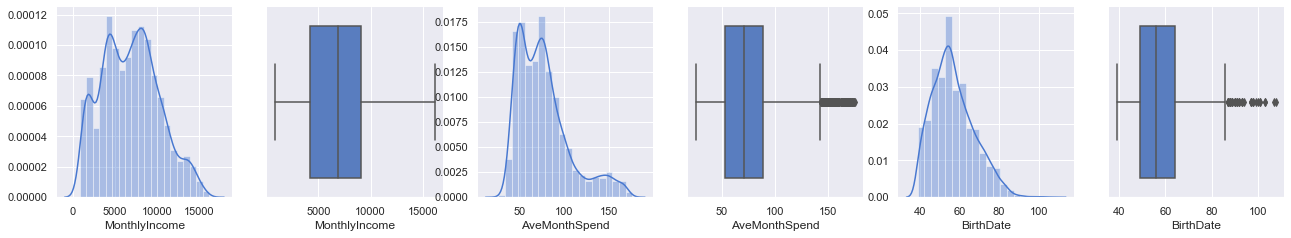

In [19]:
# plotting the distribution of the continous feature set
sns.set(palette='muted', color_codes=True)
fig, axs = plt.subplots(1, 6, figsize=(22, 3.5))
sns.despine(left=True)
sns.distplot(train['MonthlyIncome'], bins=20, ax=axs[0])
sns.distplot(train['AveMonthSpend'], bins=20, ax=axs[2])
sns.distplot(train['BirthDate'], bins=20, ax=axs[4])
sns.boxplot(train['MonthlyIncome'], ax=axs[1])
sns.boxplot(train['AveMonthSpend'], ax=axs[3])
sns.boxplot(train['BirthDate'], ax=axs[5])
plt.show()

Of the three continuous columns in the dataset, it appears the Birthdate column is normally distributed with no outliers, but this is not the case for the Yearly Income and Average Monthly Spend columns, and also the value range for Yearly income is widely dispersed and with outliers, hence there would be need to pre-process these columns

# Bi-Variate Analysis

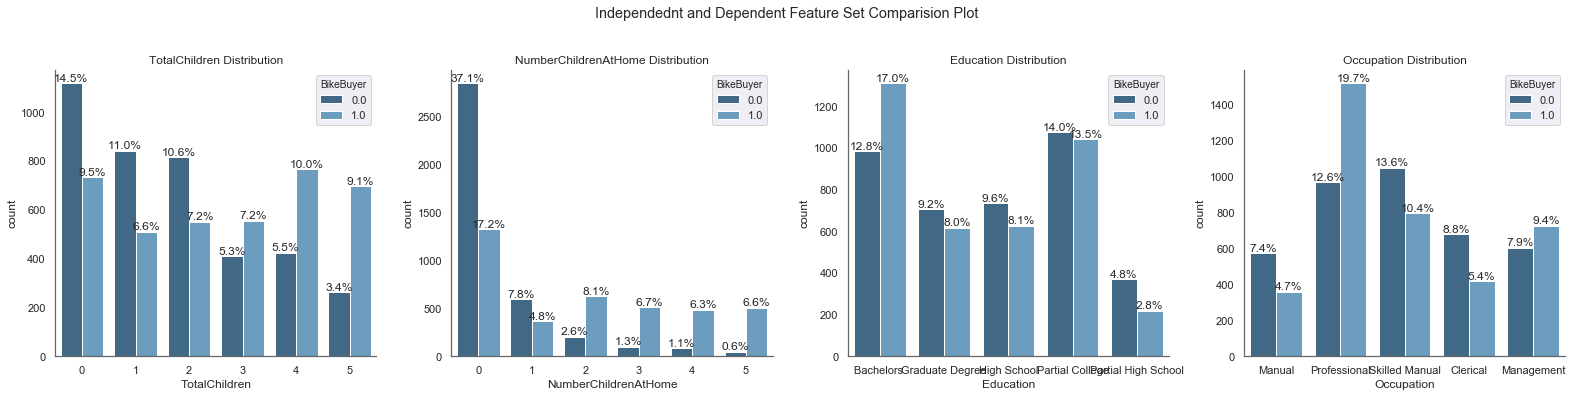

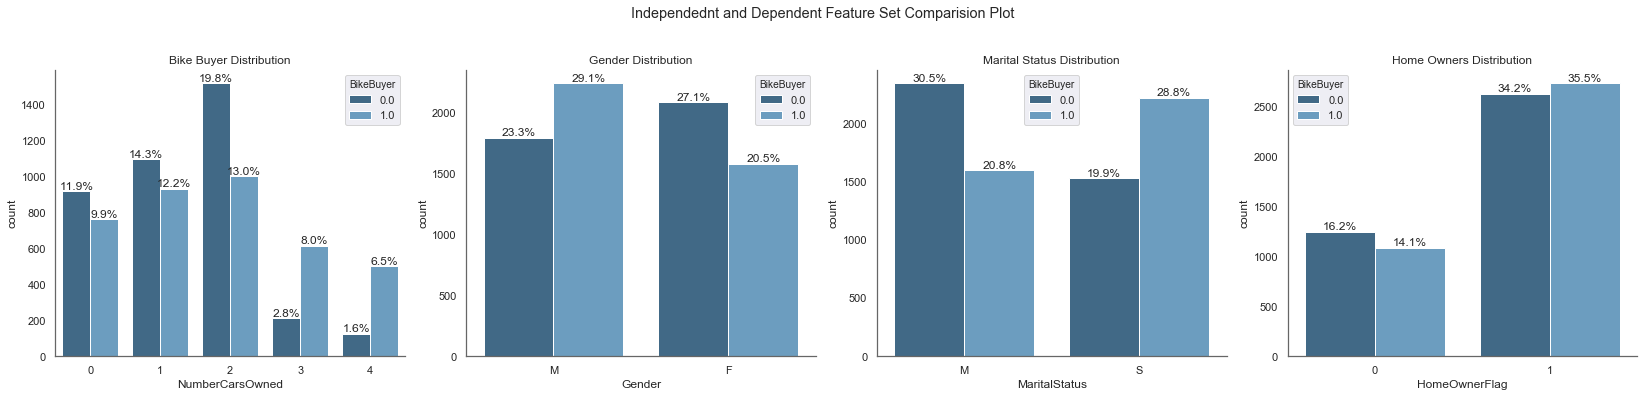

In [20]:
# displaying comparative plot between independednt and dependent feature set
fig, axs = plt.subplots(1, 4, figsize=(22, 5))
count_plot(feature='TotalChildren', df=train, ax=axs[0], hue='BikeBuyer', title='TotalChildren Distribution')
count_plot(feature='NumberChildrenAtHome', df=train, ax=axs[1], hue='BikeBuyer', title='NumberChildrenAtHome Distribution')
count_plot(feature='Education', df=train, ax=axs[2], hue='BikeBuyer', title='Education Distribution')
count_plot(feature='Occupation', df=train, ax=axs[3], hue='BikeBuyer', title='Occupation Distribution')
#format_spines(ax, right_border=False)
plt.suptitle('Independednt and Dependent Feature Set Comparision Plot', y=1.1)
plt.show()

fig, axs = plt.subplots(1, 4, figsize=(23, 5))
count_plot(feature='NumberCarsOwned', df=train, ax=axs[0], hue='BikeBuyer', title='Bike Buyer Distribution')
count_plot(feature='Gender', df=train, ax=axs[1], hue='BikeBuyer', title='Gender Distribution')
count_plot(feature='MaritalStatus', df=train, ax=axs[2], hue='BikeBuyer', title='Marital Status Distribution')
count_plot(feature='HomeOwnerFlag', df=train, ax=axs[3], hue='BikeBuyer', title='Home Owners Distribution')
#format_spines(ax, right_border=False)
plt.suptitle('Independednt and Dependent Feature Set Comparision Plot', y=1.1)
plt.show()

The above plot shows the relationship between each of the categorical feature set and the target set BikeBuyer, its unique values, and frequency count. 

From the first plot, it appears that from the 24.1%(1852) of the dataset that has 0 children, 14.5%(1114) were non-BikeBuyers and 9.5%(761) were BikeBuyers. Out of the 17.6 (1352) of the dataset that had 1 child, 11%(1114) were non-BikeBuyers and 6.6%(507) were BikeBuyers. . . ., and 12.5%(961) have 5 children. In essence, the trend here is the more children a customer has the more likely he/she would purchase a bike

.

.

.

From the Last plot, from the 30.3%(2328) of the dataset that has 0 House, 16.2%(1245) were non-BikeBuyers and 14.1%(1083) were BikeBuyers, also from the 69.7%(5356) of the dataset that has 1 House, 34.2%(2628) were non-BikeBuyers and 35.5%(2727) were BikeBuyers. the trend here is that customers who own houses are more likely to buy a bike than customers who don't own houses. 

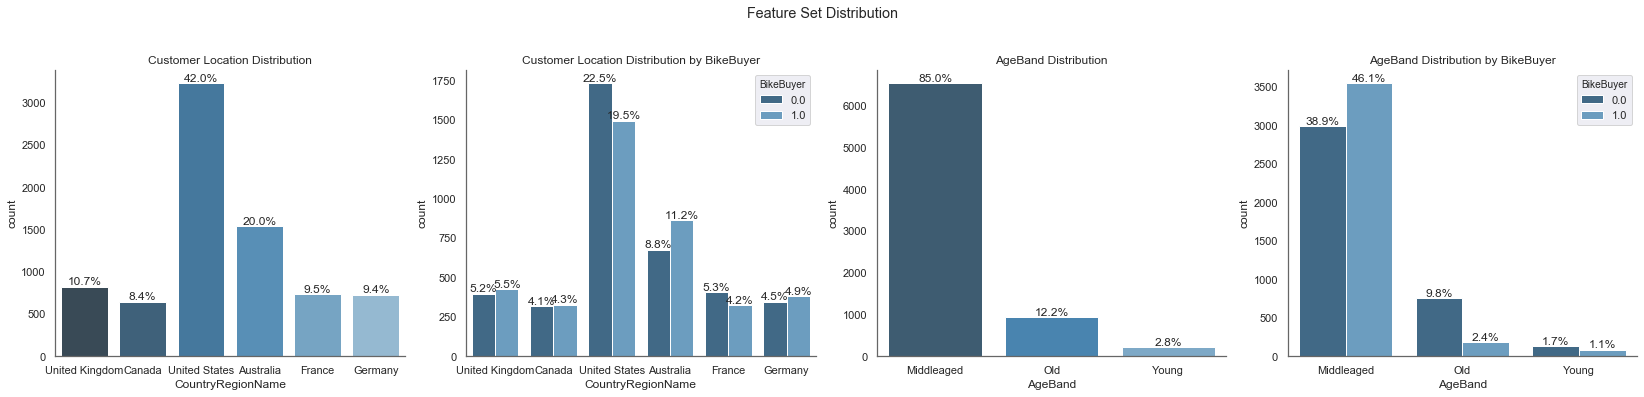

In [21]:
# displaying comparative plot between independednt and dependent feature set
fig, axs = plt.subplots(1, 4, figsize=(23, 5))
count_plot(feature='CountryRegionName', df=train, ax=axs[0], title='Customer Location Distribution')
count_plot(feature='CountryRegionName', df=train, ax=axs[1], hue='BikeBuyer', title='Customer Location Distribution by BikeBuyer')
count_plot(feature='AgeBand', df=train, ax=axs[2], title='AgeBand Distribution')
count_plot(feature='AgeBand', df=train, ax=axs[3], hue='BikeBuyer', title='AgeBand Distribution by BikeBuyer')
plt.suptitle('Feature Set Distribution', y=1.1)
plt.show()

The above plots show the relationship between customer location, the newly generated column AgeBand and the Target column BikeBuyer.

From the first count plot it is observed the majority of customers are located in the USA(42%), Australia(20%), UK(10.7%), . . ., and finally Canada(8.4%).

The second plot shows the distribution of BikeBuyers and non-Bikebuyers with respect to customer location.

The third plot shows the distribution of customer AgeBands, it's Observed that the majority of the customer in the dataset are Middleaged, followed by Old then finally Young customers.

The fourth plot shows the distribution of BikeBuyers and non-Bikebuyers with respect to AgeBand.

# Multi-variate Analysis

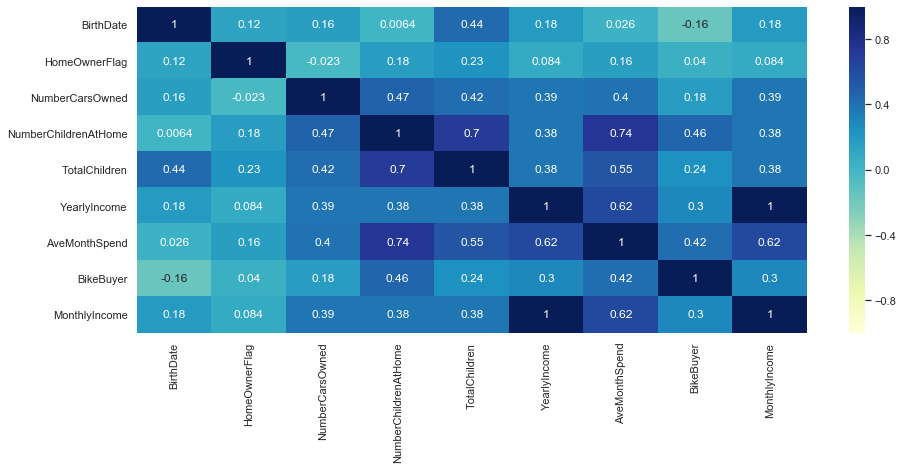

In [22]:
# plotting correlation heatmap
fig, ax = plt.subplots()
fig.set_size_inches(15, 6)
corr_matrix = train.corr()
ax=sns.heatmap(corr_matrix, vmin=-1, cmap="YlGnBu", annot=True)

The above heatmap plot shows the correlation between the various numeric columns, it shows by how much each column correlates to other columns and most especially the target column BikeBuyer. As seen above, NumberChildrenAtHome, AverMonthSpend, MonthlyIncome has a stronger positive correlation with BikeBuyer and Birthdate has a slightly negative correlation with BikeBuyer

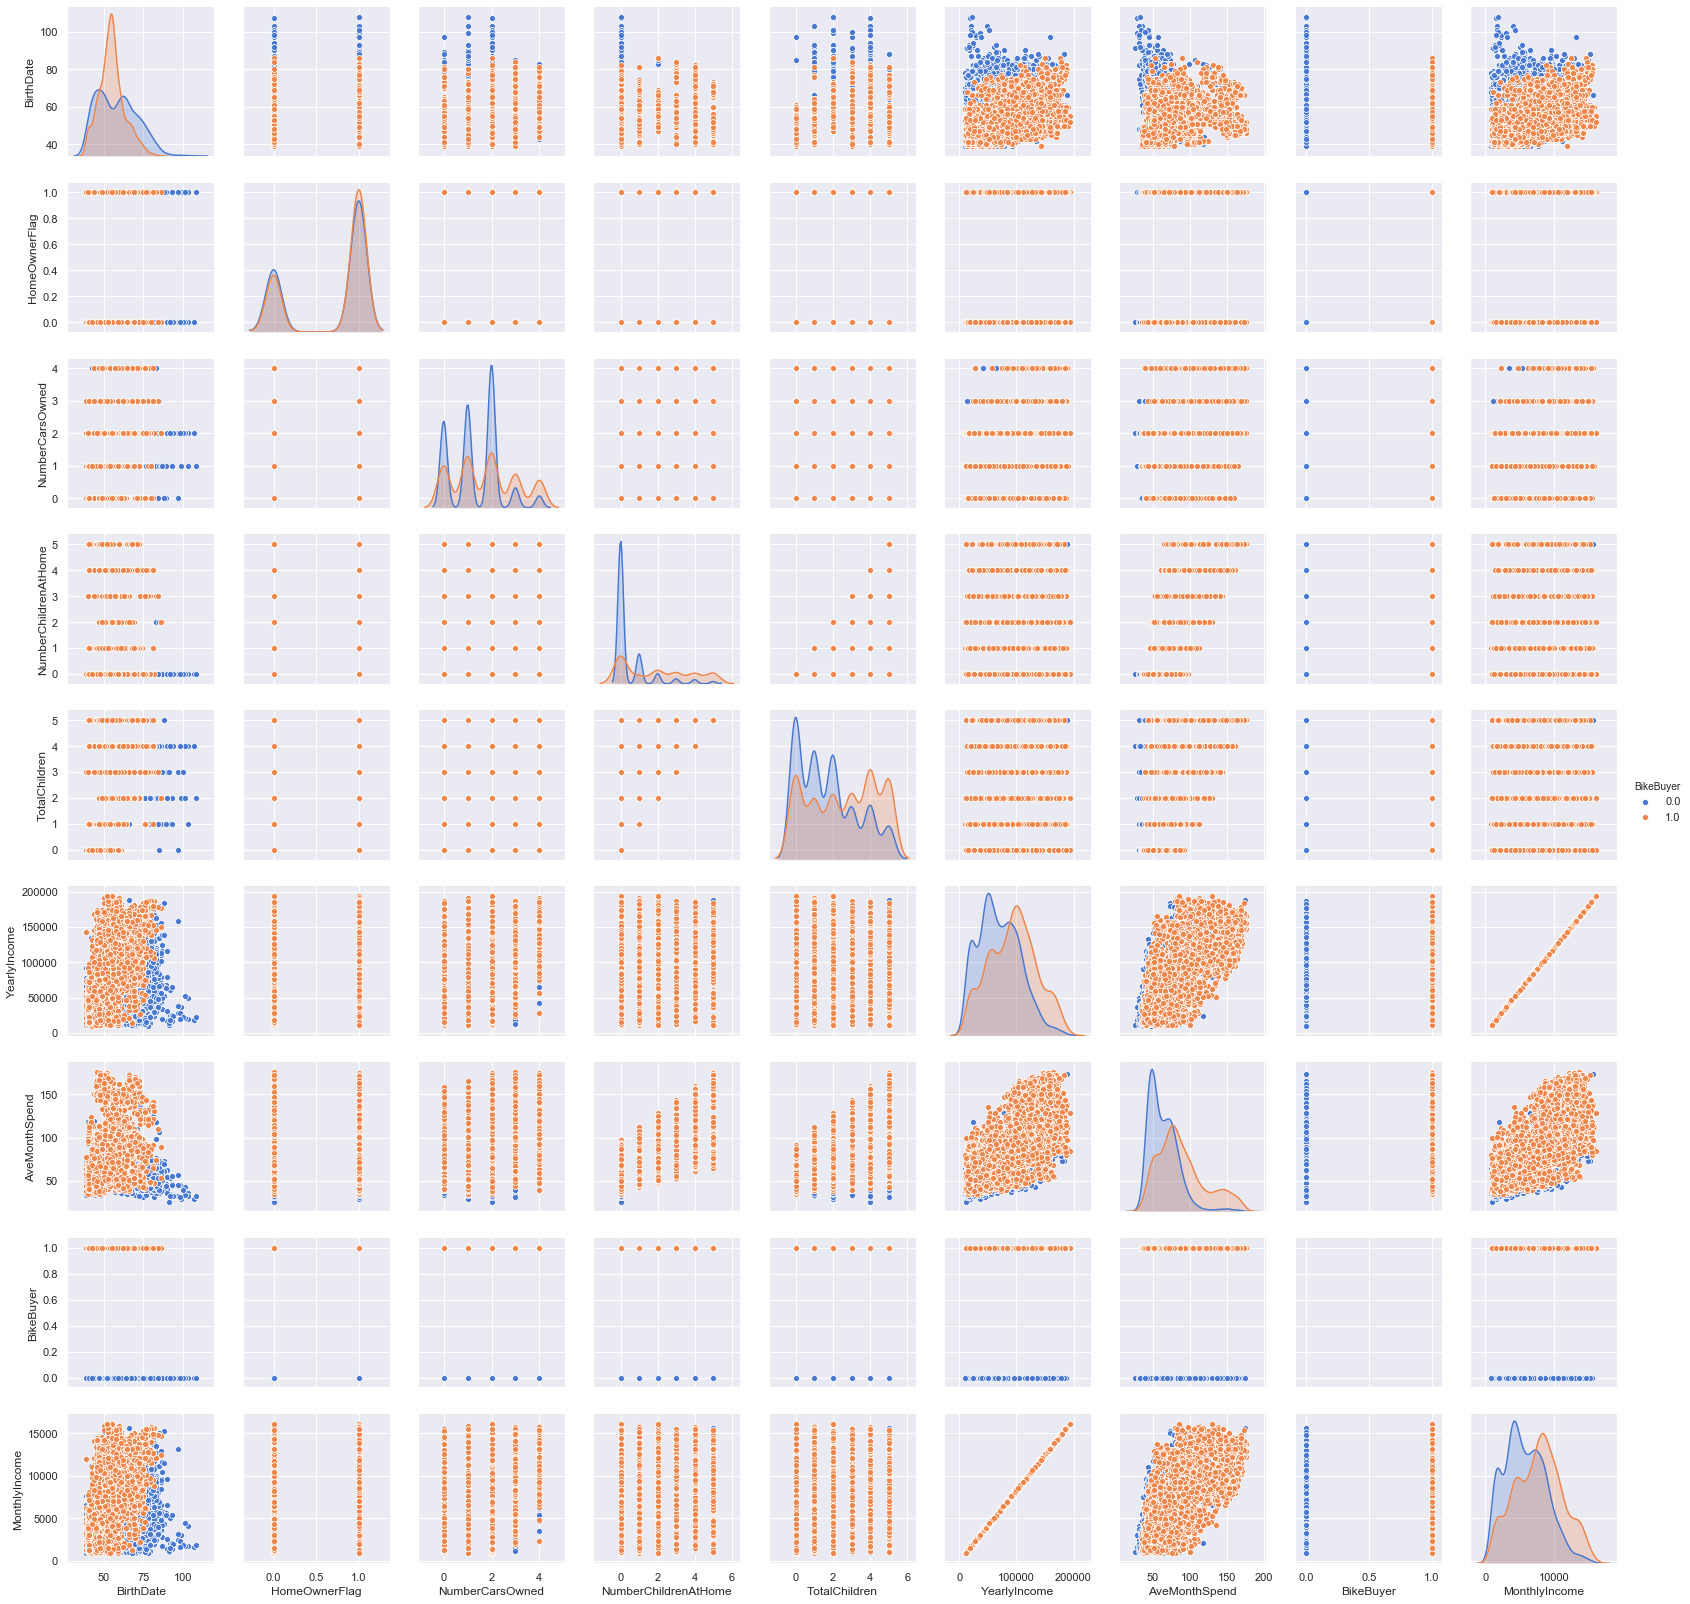

In [23]:
# pairplot showing relationship between features with respect to target set
sns.pairplot(train, hue='BikeBuyer')
plt.show()

The above plot shows the relationship between each of the feature sets with each other with respect to the targetset BikeBuyer. I would further explore that of the features with high correlation with the target set BikeBuyer.

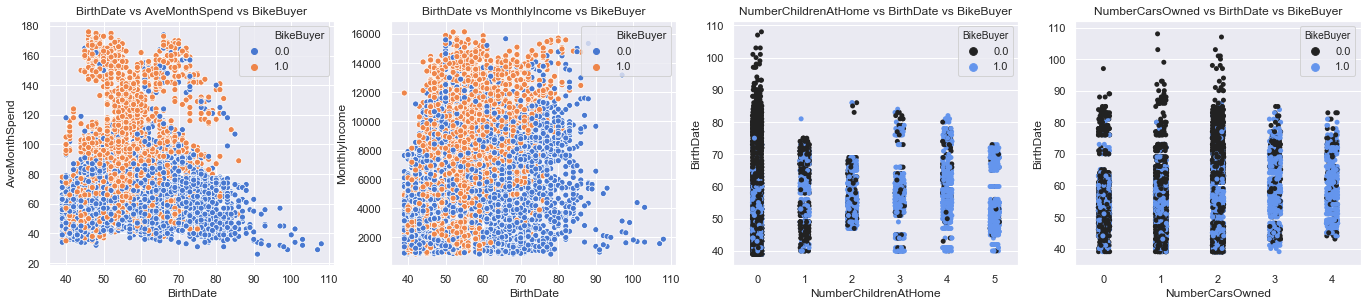

In [24]:
# displaying comparative plot between independednt and dependent feature set
f, axes = plt.subplots(ncols=4, figsize=(23.5,4.5))
colors = 'cornflowerblue'
sns.scatterplot(x="BirthDate", y="AveMonthSpend", hue='BikeBuyer', data=train, color=colors, ax=axes[0])
axes[0].set_title('BirthDate vs AveMonthSpend vs BikeBuyer')
sns.scatterplot(x="BirthDate", y="MonthlyIncome", hue='BikeBuyer', data=train, color=colors, ax=axes[1])
axes[1].set_title('BirthDate vs MonthlyIncome vs BikeBuyer')
sns.stripplot(x="NumberChildrenAtHome", y="BirthDate", data=train,  hue='BikeBuyer', jitter=True, color=colors, ax=axes[2])
axes[2].set_title('NumberChildrenAtHome vs BirthDate vs BikeBuyer')
sns.stripplot(x="NumberCarsOwned", y="BirthDate", hue='BikeBuyer', data=train, color=colors, ax=axes[3])
axes[3].set_title('NumberCarsOwned vs BirthDate vs BikeBuyer')
plt.show()

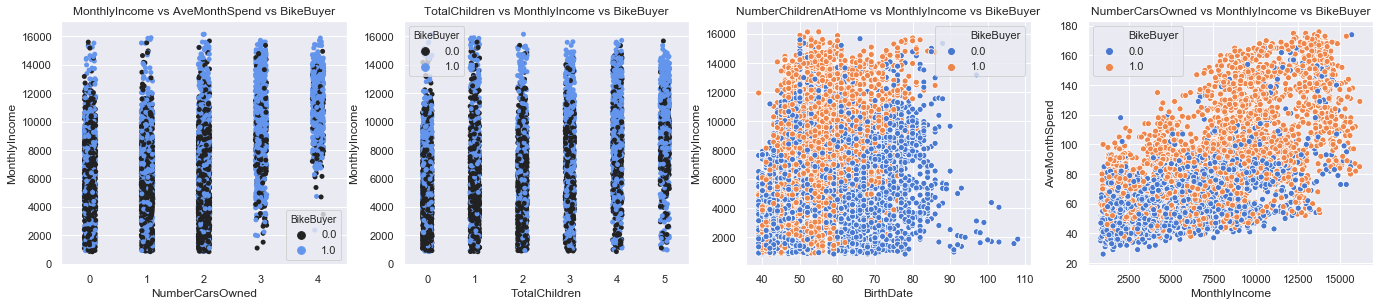

In [25]:
# displaying comparative plot between independednt and dependent feature set
f, axes = plt.subplots(ncols=4, figsize=(23.5,4.5))
colors = 'cornflowerblue'
sns.scatterplot(x="MonthlyIncome", y="AveMonthSpend", hue='BikeBuyer', data=train, color=colors, ax=axes[3])
axes[0].set_title('MonthlyIncome vs AveMonthSpend vs BikeBuyer')
sns.scatterplot(x="BirthDate", y="MonthlyIncome", hue='BikeBuyer', data=train, color=colors, ax=axes[2])
axes[1].set_title('TotalChildren vs MonthlyIncome vs BikeBuyer')
sns.stripplot(x="TotalChildren", y="MonthlyIncome", data=train,  hue='BikeBuyer', jitter=True, color=colors, ax=axes[1])
axes[2].set_title('NumberChildrenAtHome vs MonthlyIncome vs BikeBuyer')
sns.stripplot(x="NumberCarsOwned", y="MonthlyIncome", hue='BikeBuyer', data=train, color=colors, ax=axes[0])
axes[3].set_title('NumberCarsOwned vs MonthlyIncome vs BikeBuyer')
plt.show()

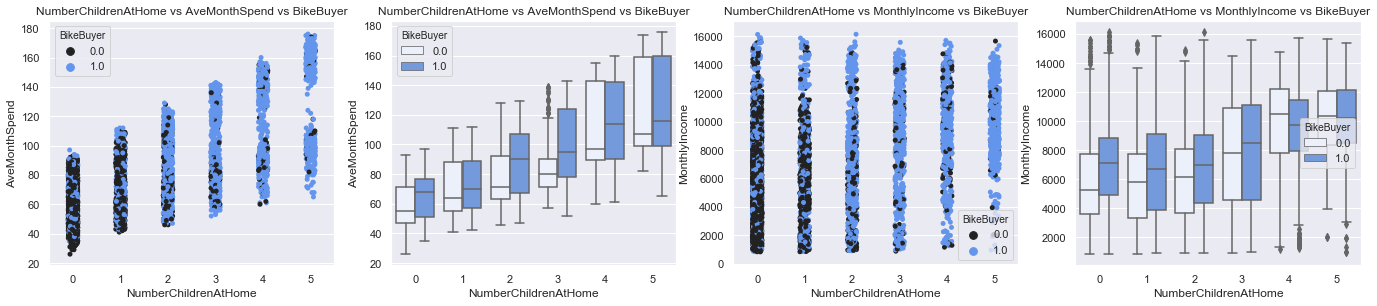

In [26]:
# displaying comparative plot between independednt and dependent feature set
f, axes = plt.subplots(ncols=4, figsize=(23.5,4.5))
colors = 'cornflowerblue'
sns.stripplot(x="NumberChildrenAtHome", y="AveMonthSpend", hue='BikeBuyer', data=train, color=colors, ax=axes[0])
axes[0].set_title('NumberChildrenAtHome vs AveMonthSpend vs BikeBuyer')
sns.boxplot(x="NumberChildrenAtHome", y="AveMonthSpend", hue='BikeBuyer', data=train, color=colors, ax=axes[1])
axes[1].set_title('NumberChildrenAtHome vs AveMonthSpend vs BikeBuyer')
sns.stripplot(x="NumberChildrenAtHome", y="MonthlyIncome", data=train,  hue='BikeBuyer', jitter=True, color=colors, ax=axes[2])
axes[2].set_title('NumberChildrenAtHome vs MonthlyIncome vs BikeBuyer')
sns.boxplot(x="NumberChildrenAtHome", y="MonthlyIncome", hue='BikeBuyer', data=train, color=colors, ax=axes[3])
axes[3].set_title('NumberChildrenAtHome vs MonthlyIncome vs BikeBuyer')
plt.show()

The above plots show the relationship between the top 3 positively correlated independent columns(NumberChildrenAtHome, AveMonthSpend,  MonthlyIncome) and the dependent column(BikeBuyer). 

From the first strip plot it is observed that the average monthly spend of each household is positively correlated with the number of children, the more the children the greater the band of the AverageMonthSpend and also customers with more children at home are mostly BikeBuyera as the strip with more children is dominated with light blue dots which indicates BikeBuyers and the opposite for the case of 0 children

The second boxplot shows the same relationship, but with the various AverageMonthSpend percentile ranges for both BikeBuyers and non-BikeBuyers. For those with 0 children, non-buyers have a lower 25th, 50th, and 75th percentile AverageMonthSpend when compared to the BikeBuyers, . . ., for those with 5 children they share very close 25th and 75th percentile but different AverageMonthSpend as it is seen that the BikeBuyers tend to spend more on an average than the non-BikeBuyers. 
..
The same can be said for the third and fourth plots showing statistics of the comparison with the Monthly Income.

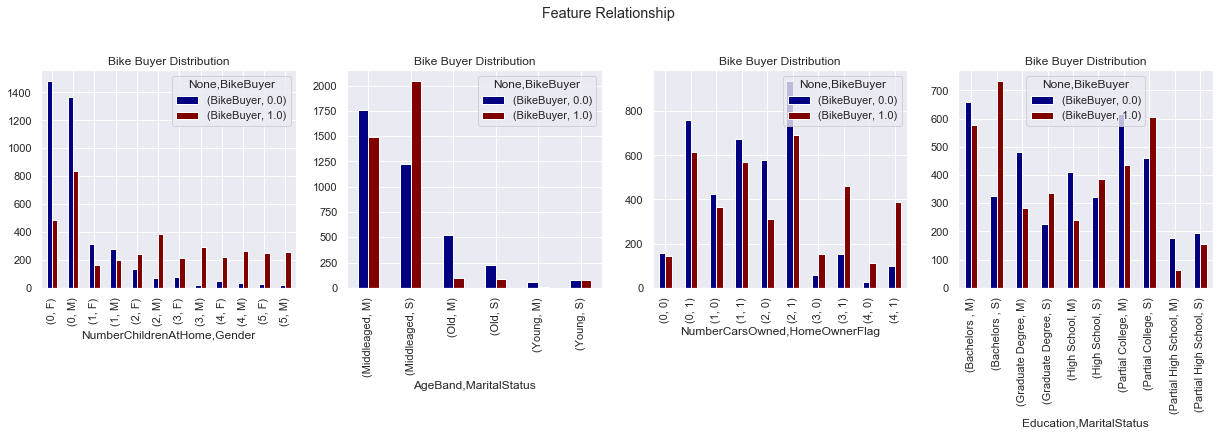

In [27]:
# plotting relationship between mitivariate columns
fig, ax = plt.subplots(1, 4, figsize=(21, 4))
sns.set(palette='muted', color_codes=True)
train.groupby(['NumberChildrenAtHome', 'Gender', 'BikeBuyer'])[['BikeBuyer']].count().unstack().plot.bar(ax=ax[0], title='Bike Buyer Distribution', cmap='jet')
train.groupby(['AgeBand', 'MaritalStatus', 'BikeBuyer'])[['BikeBuyer']].count().unstack().plot.bar(ax=ax[1], title='Bike Buyer Distribution', cmap='jet')
train.groupby(['NumberCarsOwned', 'HomeOwnerFlag', 'BikeBuyer'])[['BikeBuyer']].count().unstack().plot.bar(ax=ax[2], title='Bike Buyer Distribution', cmap='jet')
train.groupby(['Education', 'MaritalStatus', 'BikeBuyer'])[['BikeBuyer']].count().unstack().plot.bar(ax=ax[3], title='Bike Buyer Distribution', cmap='jet')
#format_spines(ax, right_border=False)
plt.suptitle('Feature Relationship', y=1.1)
plt.show()

The above plot shows grouped bikebuyer analysis, the first plot shows the number of female and male customers with 0 children that bought and did not buy bikes up to those with 5 children. It is easily seen that the more children a customer has the more the chances of that client buying a bike and vice versa.
The second plot shows the number of home owner and non-home owner customers with 0 t0 4 cars that bought and did not buy bikes. It is seen here that the single middleaged customer are better bikebuyes than the marries middleaged customers, also married old customers are less likely to buy bikes when compared to the single old customers. The married young customers wont buy bikes while the single young customers are majorly indefferent. 
The third plot shows grouped relationship between clients who owns from 0 to 4 number of cars and at the same time own and do not own houses with respect to bike buyers and non bikebuyers. The pattern here is the more 
The last plot shows the relationship between customers educational and marital status with respect to bike buyers. for the category the major bikebuyers are single bachelors and major non-bike buyers are between single customers with partial degrees and married bachelors.

There are tons of analysis that can be done but for now i would limit it to these few

# Further Feature Engineering

In [28]:
df.head(3)

City StateProvinceName CountryRegionName PostalCode  BirthDate  \
x 0     London           England    United Kingdom    W1Y 3RA         61   
  1  Cliffside  British Columbia            Canada    V8Y 1L1         59   
  2  Metchosin  British Columbia            Canada         V9         50   

      Education      Occupation Gender MaritalStatus  HomeOwnerFlag  \
x 0  Bachelors           Manual      M             M              1   
  1  Bachelors     Professional      M             S              0   
  2  Bachelors   Skilled Manual      M             M              1   

     NumberCarsOwned  NumberChildrenAtHome  TotalChildren  YearlyIncome  \
x 0                0                     0              1         35455   
  1                1                     0              0         43980   
  2                0                     2              2         57713   

     AveMonthSpend  BikeBuyer     AgeBand  MonthlyIncome  
x 0             70        1.0  Middleaged           2955  
  1             69        0.0  Middleaged           3665  
  2            102        0.0  Middleaged           4810

In [29]:
# client_buyer column for client who have the most chance of buying
def client_rank(TotalChildren, NumberChildrenAtHome, NumberCarsOwned):
    
    if TotalChildren >= 4 and NumberChildrenAtHome >= 2 and NumberCarsOwned >= 3:
     return 1
    else:
     return 0
     
df['client_buyer'] = df.apply(lambda x : client_rank(x['TotalChildren'], x['NumberChildrenAtHome'], x['NumberCarsOwned']), axis=1)

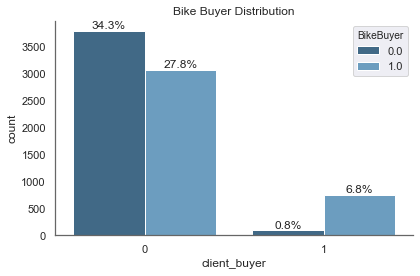

In [30]:
# plotting generated feature
count_plot(feature='client_buyer', df=df, hue='BikeBuyer', title='Bike Buyer Distribution')
plt.show()

# Preprocessing

In [31]:
# mapping numbers to categorical columns
df['Gender'] = df['Gender'].apply(lambda x: 0 if x=='F' else 1)
df['MaritalStatus'] = df['MaritalStatus'].apply(lambda x: 0 if x=='S' else 1)
df['AgeBand'] = df['AgeBand'].apply(lambda x: 0 if x=='S' else 1)

In [32]:
#dropping non useful columns
df = df.drop(["City", "CountryRegionName", "PostalCode", "YearlyIncome"], axis=1)

In [33]:
# spliting df to train and test dataset
train = df.loc['x']
test = df.loc['y']

In [34]:
# creating train polynomial features
from sklearn.preprocessing import PolynomialFeatures

poly_train = train.loc[:, ['BirthDate', 'AveMonthSpend', 'MonthlyIncome']]
poly = PolynomialFeatures(degree=3, interaction_only=True)
polynomials_train = pd.DataFrame(poly\
                           .fit_transform(poly_train), 
                           columns=['0','1','2','3', 
                                    'p1', 'p2', 'p3', 'p4'])[['p1', 'p2', 'p3', 'p4',]]
train = pd.concat([train, polynomials_train], axis=1)

In [35]:
# creating test polynomial features
poly_test = test.loc[:, ['BirthDate', 'AveMonthSpend', 'MonthlyIncome']]
poly = PolynomialFeatures(degree=3, interaction_only=True)
polynomials_test = pd.DataFrame(poly\
                           .fit_transform(poly_test), 
                           columns=['0','1','2','3', 
                                    'p1', 'p2', 'p3', 'p4'])[['p1', 'p2', 'p3', 'p4',]]
test = pd.concat([test, polynomials_test], axis=1)

In [36]:
# Robust scaling continous train numerical colums due to presence of outliers and difference in column ranges
s_scal = train[['BirthDate', 'AveMonthSpend', 'MonthlyIncome', 'p1', 'p2', 'p3', 'p4']]
s_scale = RobustScaler(quantile_range=(1, 99)).fit(train[['BirthDate', 'AveMonthSpend', 'MonthlyIncome', 'p1', 'p2', 'p3', 'p4']])
df_scale = s_scale.transform(train[['BirthDate', 'AveMonthSpend', 'MonthlyIncome', 'p1', 'p2', 'p3', 'p4']])
df_scale = pd.DataFrame(df_scale, columns=s_scal.columns)
train = train.drop(["BirthDate", "AveMonthSpend", "MonthlyIncome","p1","p2","p3", "p4"], axis=1)
train = train.join(df_scale)

# Robust scaling continous test numerical colums due to presence of outliers and difference in column ranges
s_scale_ = RobustScaler(quantile_range=(1, 99)).fit(test[['BirthDate', 'AveMonthSpend', 'MonthlyIncome', 'p1', 'p2', 'p3', 'p4']])
df_test_scale = s_scale_.transform(test[['BirthDate', 'AveMonthSpend', 'MonthlyIncome', 'p1', 'p2', 'p3', 'p4']])
df_test_scale = pd.DataFrame(df_test_scale, columns=s_scal.columns)
test = test.drop(["BirthDate", "AveMonthSpend", "MonthlyIncome", "p1", "p2", "p3", "p4", "BikeBuyer"], axis=1)
test = test.join(df_test_scale)

In [37]:
# saving a copy of train and test data for catboost
train_cat = train.copy()
test_cat = test.copy()

In [38]:
# OneHot encoding train categorical colums
encode = OneHotEncoder().fit(df[['StateProvinceName', 'Education', 'Occupation','AgeBand']])
df_trans = encode.transform(train[['StateProvinceName', 'Education', 'Occupation','AgeBand']]).toarray()
cnames = encode.get_feature_names()
df_trans = pd.DataFrame(df_trans, columns=cnames)
train = train.join(df_trans)
train = train.drop(["StateProvinceName", "Education", "Occupation", "AgeBand"], axis=1)

# OneHot encoding test categorical colums
df_test_trans = encode.transform(test[['StateProvinceName', 'Education', 'Occupation','AgeBand']]).toarray()
df_test_trans = pd.DataFrame(df_test_trans, columns=cnames)
test = test.join(df_test_trans)
test = test.drop(["StateProvinceName", "Education", "Occupation", "AgeBand"], axis=1)

In [39]:
# mapping and spliting train and test data
X = train.drop('BikeBuyer', axis=1)
y = train['BikeBuyer']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.30, random_state=random)

In [40]:
# defining and fitting classifiers
classifiers = {
    'log_reg': LogisticRegression(random_state = random),
    'sgd_clf': SGDClassifier(random_state = random),
    'ext_clf': ExtraTreeClassifier(random_state = random),
    'dct_clf': DecisionTreeClassifier(random_state = random),
    'rfc_clf': RandomForestClassifier(random_state = random),
    'mlp_clf': MLPClassifier(random_state = random),
    'knc_clf': KNeighborsClassifier(),
    'lsv_reg': LinearSVC(random_state = random),
    'nsv_clf': NuSVC(random_state = random),
    'svc_clf': SVC(random_state = random),
}

trained_models = {}

for key, model in classifiers.items():
    model.fit(X_train, y_train)
    trained_models[key] = model

In [41]:
# Creating dataframe to hold, evaluate and print metrics
cv = ShuffleSplit(n_splits=5, test_size=0.2, random_state=42)

train_performance = create_dataset()

train_performance = model_analysis(trained_models, X_train, y_train, train_performance)

cm = sns.light_palette("cornflowerblue", as_cmap=True)
train_performance.style.background_gradient(cmap=cm)

,acc,prec,rec,f1,auc,total_time
log_reg,0.7572,0.77,0.7271,0.7478,0.8448,0.99
sgd_clf,0.7507,0.7509,0.75,0.7479,0.8313,2.348
ext_clf,0.7003,0.697,0.6993,0.6979,0.7003,0.519
dct_clf,0.7131,0.7098,0.7117,0.7107,0.7131,1.654
rfc_clf,0.7514,0.7736,0.705,0.7374,0.8235,2.298
mlp_clf,0.7559,0.762,0.7376,0.7494,0.8406,122.058
knc_clf,0.7418,0.7432,0.7316,0.7373,0.8098,6.529
lsv_reg,0.7617,0.7769,0.7279,0.7515,0.8459,10.307
nsv_clf,0.7617,0.7839,0.7162,0.7484,0.8419,62.445
svc_clf,0.7578,0.7942,0.6899,0.7381,0.842,46.429


The above table holds the metrics of various classifiers trained on the same dataset and predicted on a single test set. it shows their individual accuracy, precision, recall, f1, AUC score and computation time.

The LinearSVC appears to have the best score and a moderate computational time, Logistic reg came second in performance with a lesser computational time when compared to that of MLP, . . ., ExtraTreeClassifier came in at the bottom performance.

In [42]:
def plot_learning_curve(trained_models, X, y, ylim=None, cv=5, n_jobs=1, 
                        train_sizes=np.linspace(.1, 1.0, 10)):
    fig, axs = plt.subplots(nrows=5, ncols=2, figsize=(14, 20))
    if ylim is not None:
        plt.ylim(*ylim)
    i = 0
    j = 0
    for key, model in trained_models.items():
        train_sizes, train_scores, test_scores = learning_curve(model, X, y, cv=cv, n_jobs=n_jobs, 
                                                                train_sizes=train_sizes)
        train_scores_mean = np.mean(train_scores, axis=1)
        train_scores_std = np.std(train_scores, axis=1)
        test_scores_mean = np.mean(test_scores, axis=1)
        test_scores_std = np.std(test_scores, axis=1)
        axs[i, j].fill_between(train_sizes, train_scores_mean - train_scores_std,
                               train_scores_mean + train_scores_std, alpha=0.1, color='blue')
        axs[i, j].fill_between(train_sizes, test_scores_mean - test_scores_std,
                               test_scores_mean + test_scores_std, alpha=0.1, color='crimson')
        axs[i, j].plot(train_sizes, train_scores_mean, 'o-', color="navy",
                       label="Training score")
        axs[i, j].plot(train_sizes, test_scores_mean, 'o-', color="red",
                       label="Cross-Validation score")
        axs[i, j].set_title(f'{key} Learning Curve', size=14)
        axs[i, j].set_xlabel('Training size (m)')
        axs[i, j].set_ylabel('Score')
        axs[i, j].grid(True)
        axs[i, j].legend(loc='best')
        j += 1
        if j == 2:
            i += 1
            j = 0

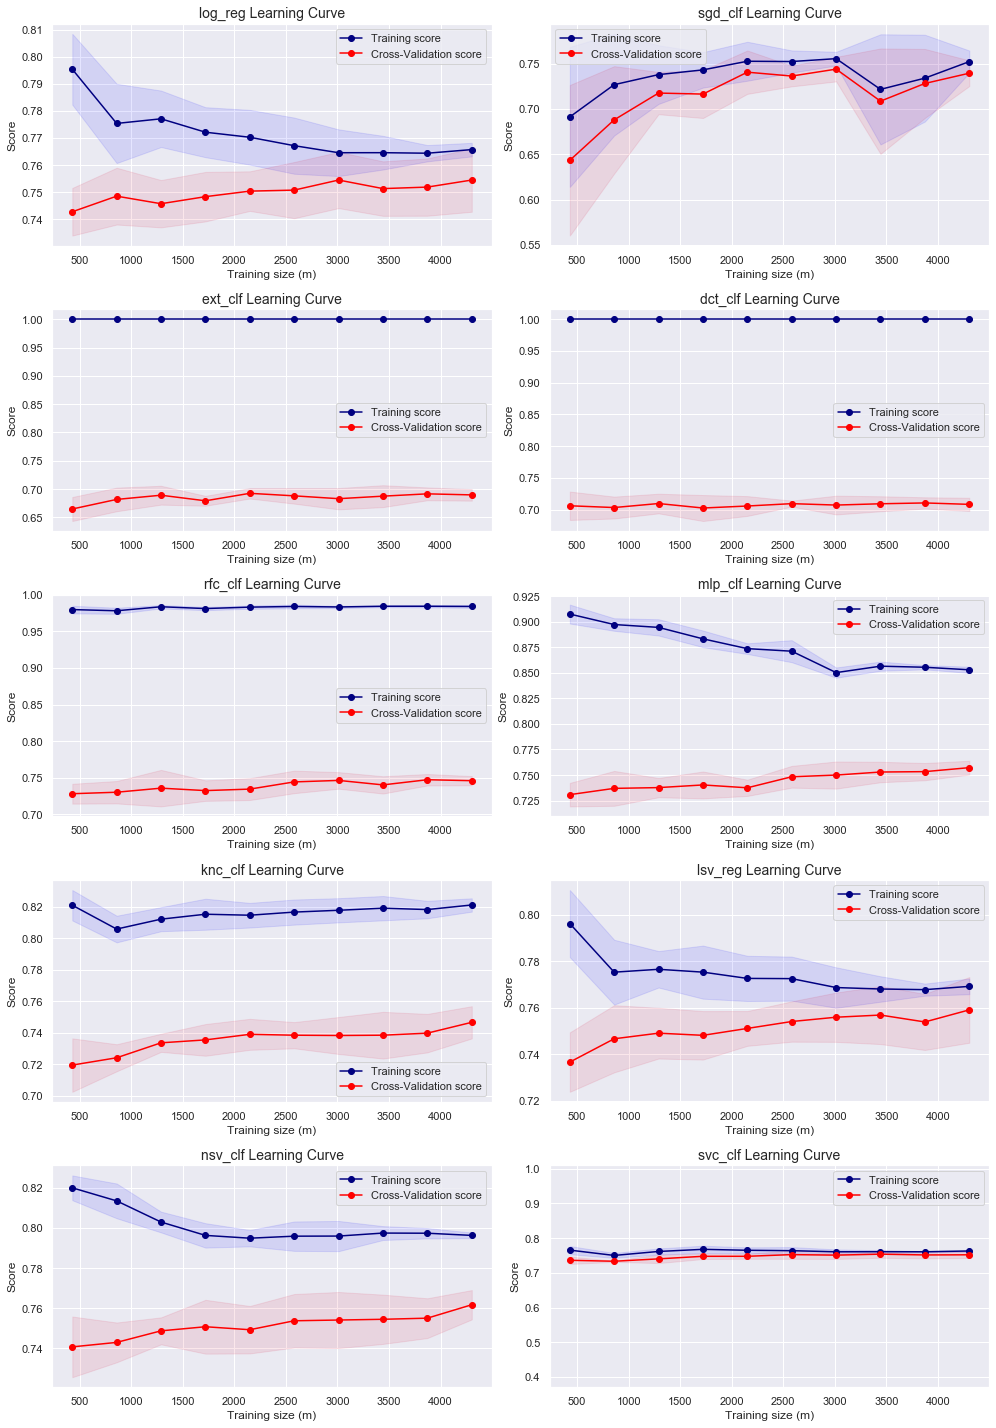

In [43]:
# computing and visualizing train learning curve
cv = ShuffleSplit(n_splits=5, test_size=0.2, random_state=42)
plot_learning_curve(trained_models, X_train, y_train, (0.37, 1.01), cv=cv, n_jobs=4)
plt.tight_layout()

The above curve displays the learning rate of each of the classifiers on the train set, the blue curve indicates the training score and the red indicates the 5 folds cross-validation score.

Too close to each other the plot indicates a problem of overfitting, too far apart then its a case of underfitting. So the better performing model will have both curves close but not too close and example is the SVC classifier 

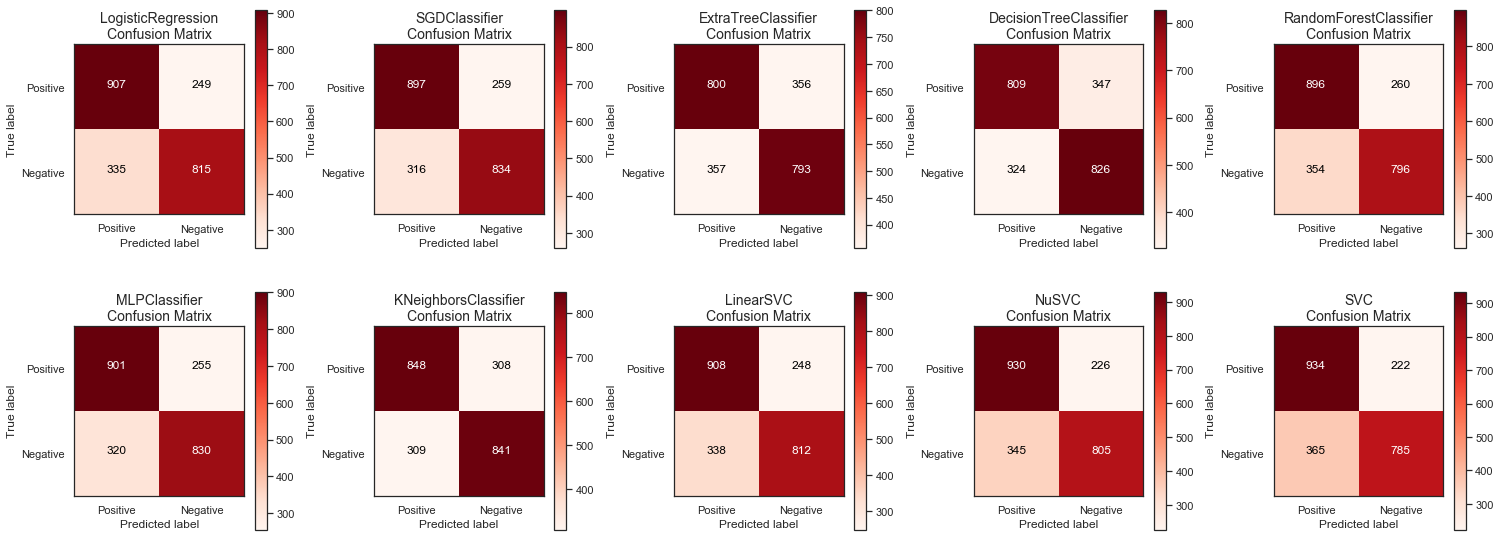

In [44]:
# computing and visualizing test confusion matrix
model_confusion_matrix(trained_models, X_test, y_test, cmap=plt.cm.Reds)

The Above confusion matrix shows the model performance of the individual classifiers on the train data Split test set, It indicates the number of True positives(Number of BikeBuyers predicted as buyers), False positives(Number of non-BikeBuyers predicted as buyers), True negatives(Number of non-BikeBuyers predicted as non-buyers) and False negatives(Number of non-BikeBuyers predicted as buyers)

It appears the linear SVC and Logistic regression classifiers had the most correct predictions.

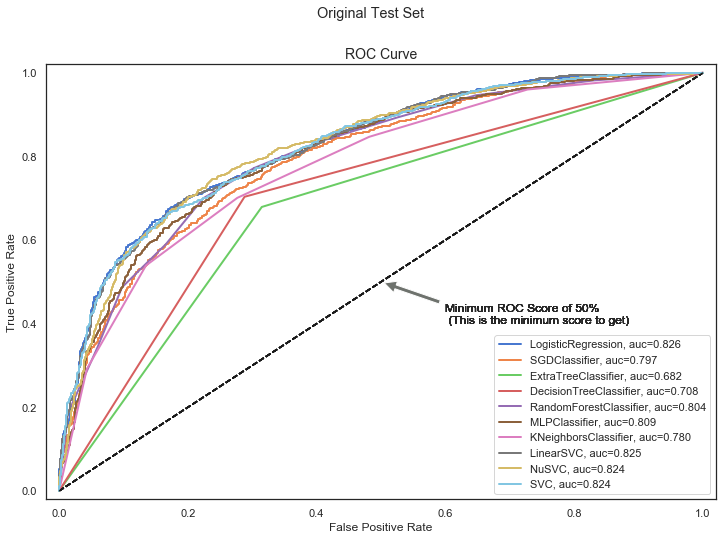

In [45]:
# computing and visualizing model set ROC Curve
plt.figure(figsize=(12, 8))

for key, model in trained_models.items():

    # Computing scores with cross_val_predict
    try:
        y_scores = cross_val_predict(model, X_test, y_test, cv=5, 
                                     method='decision_function')
    except:
        # Trees don't have decision_function but predict_proba
        y_probas = cross_val_predict(model, X_test, y_test, cv=5, 
                                     method='predict_proba')
        y_scores_tree = y_probas[:, 1]
        y_scores = y_scores_tree
        
    # ROC Curve
    model_name = model.__class__.__name__
    fpr, tpr, thresholds = roc_curve(y_test, y_scores)
    auc = roc_auc_score(y_test, y_scores)
    plot_roc_curve(fpr, tpr, y_test, y_scores, auc, label=model_name)
    plt.suptitle('Original Test Set')

In [46]:
# GBDT Models

In [47]:
# defining classifiers for voting classifier
log_reg = LogisticRegression(random_state = random)
sgd_clf = SGDClassifier(random_state = random, loss='log')
rfc_clf = RandomForestClassifier(random_state = random)
svc_clf = SVC(probability=True)
knn_clf = KNeighborsClassifier()
nsv_clf = NuSVC(random_state = random, probability = True)
lsv_clf = LinearSVC(random_state = random)

voting_clf = VotingClassifier(
    estimators=[('lr', log_reg), ('sgd_clf', sgd_clf), ('nsv_clf', nsv_clf),
                ('rfc_clf', rfc_clf), 
                ('svc_clf', svc_clf), ('knn_clf', knn_clf)],
    voting='soft')

voting_clf.fit(X_train, y_train)

# Training adaboost classifier with linear svc
ada_clf = AdaBoostClassifier(base_estimator=rfc_clf, n_estimators=200, learning_rate=0.03, random_state = random)
#)
ada_clf.fit(X_train, y_train)

# Training a Bagging model with 500 Decision Trees
gbc_clf = GradientBoostingClassifier(n_estimators=1000, subsample=0.8, max_depth=4, verbose=0, n_iter_no_change=100, learning_rate=0.03, warm_start=True, random_state = random)
#)
gbc_clf.fit(X_train, y_train)

# Training a Bagging model with 500 Decision Trees
bag_clf = BaggingClassifier(base_estimator=rfc_clf, n_estimators=200,
    max_samples=100, bootstrap=True, oob_score=True, random_state=random)

bag_clf.fit(X_train, y_train)
print('Finished')

Finished


In [48]:
ensemble_models = {
    'voting_clf': voting_clf,
    'ada_clf': ada_clf,
    'gbc_clf': gbc_clf,
    'bag_clf': bag_clf,
}

trained_e_models = {}

for key, s_model in ensemble_models.items():
    s_model.fit(X_train, y_train)
    trained_e_models[key] = s_model

# Creating dataframe to hold metrics
train_e_performance = create_dataset()

# Evaluating models
train_e_performance = model_analysis(trained_e_models, X_train, y_train, train_e_performance)

# Result
cm = sns.light_palette("cornflowerblue", as_cmap=True)
train_e_performance.style.background_gradient(cmap=cm)

,acc,prec,rec,f1,auc,total_time
voting_clf,0.7685,0.7862,0.7316,0.7576,0.8549,515.786
ada_clf,0.7598,0.769,0.7369,0.7524,0.8363,446.64
gbc_clf,0.7752,0.7828,0.756,0.7691,0.8673,98.32
bag_clf,0.7552,0.7808,0.7031,0.7398,0.8365,163.083


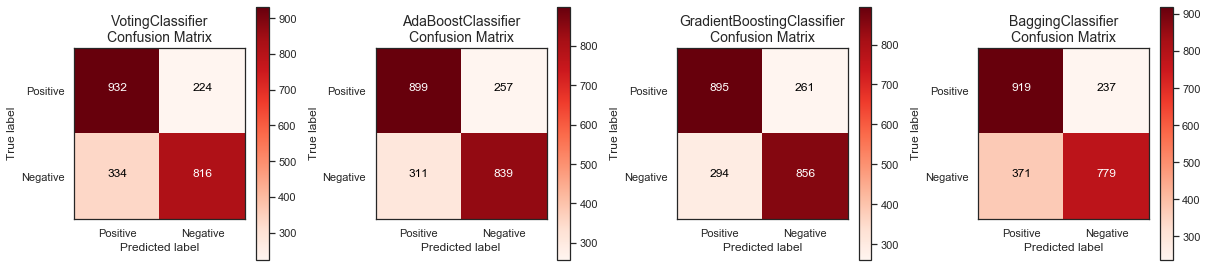

In [49]:
# computing and visualizing test confusion matrix
model_confusion_matrix(trained_e_models, X_test, y_test, cmap=plt.cm.Reds)

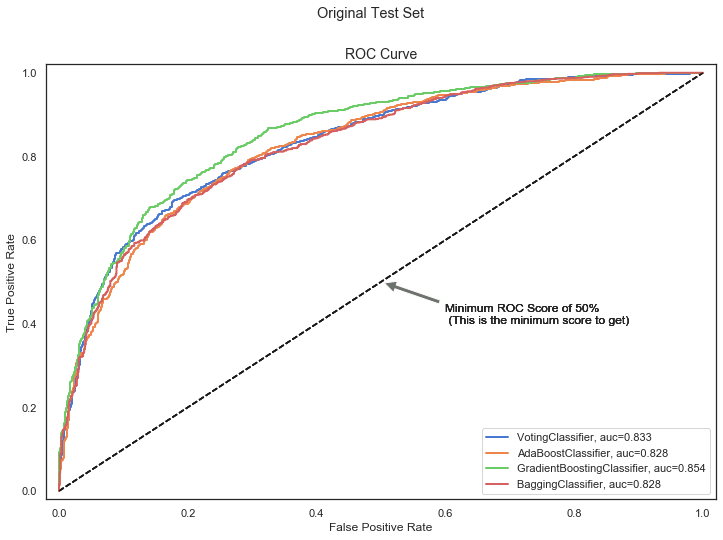

In [50]:
# computing and visualizing model set ROC Curve
plt.figure(figsize=(12, 8))

for key, model in trained_e_models.items():

    # Computing scores with cross_val_predict
    try:
        y_scores = cross_val_predict(model, X_test, y_test, cv=5, 
                                     method='decision_function')
    except:
        # Trees don't have decision_function but predict_proba
        y_probas = cross_val_predict(model, X_test, y_test, cv=5, 
                                     method='predict_proba')
        y_scores_tree = y_probas[:, 1]
        y_scores = y_scores_tree
        
    # ROC Curve
    model_name = model.__class__.__name__
    fpr, tpr, thresholds = roc_curve(y_test, y_scores)
    auc = roc_auc_score(y_test, y_scores)
    plot_roc_curve(fpr, tpr, y_test, y_scores, auc, label=model_name)
    plt.suptitle('Original Test Set')

# LGBM

Fold 0
Training until validation scores don't improve for 500 rounds
Early stopping, best iteration is:
[340]	training's auc: 0.909565	valid_1's auc: 0.867998
Fold 1
Training until validation scores don't improve for 500 rounds
Early stopping, best iteration is:
[79]	training's auc: 0.893956	valid_1's auc: 0.861457
Fold 2
Training until validation scores don't improve for 500 rounds
Early stopping, best iteration is:
[113]	training's auc: 0.895694	valid_1's auc: 0.870492
Fold 3
Training until validation scores don't improve for 500 rounds
Early stopping, best iteration is:
[104]	training's auc: 0.892696	valid_1's auc: 0.87437
Fold 4
Training until validation scores don't improve for 500 rounds
Early stopping, best iteration is:
[299]	training's auc: 0.907028	valid_1's auc: 0.867505
Average CV score: 0.86032 


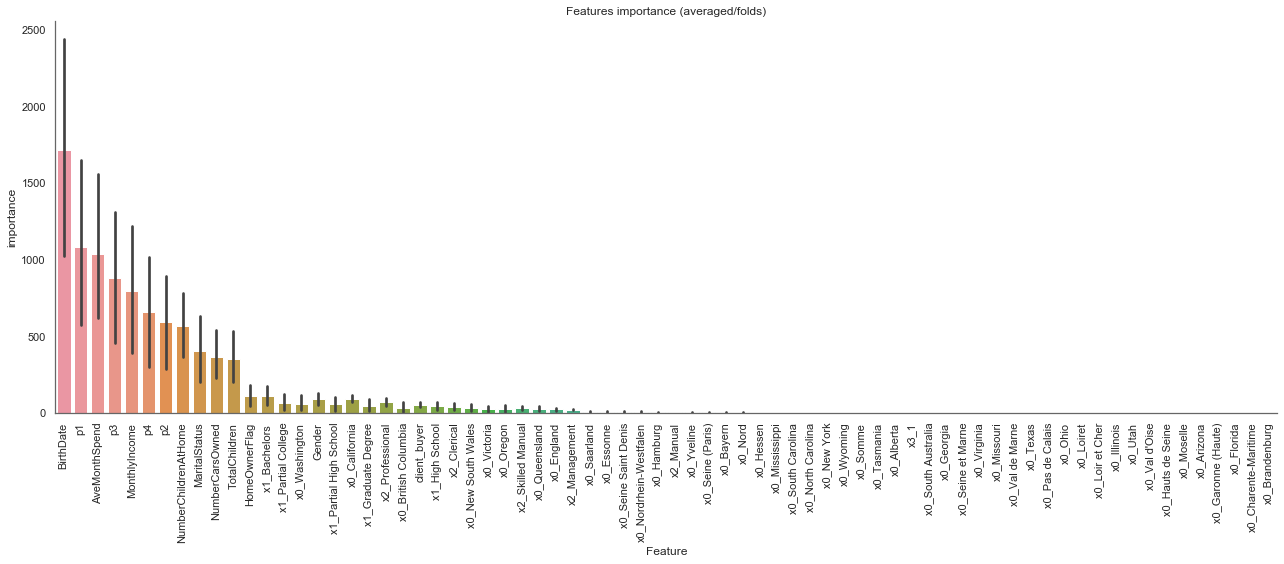

In [51]:
features = [c for c in train.columns if c not in ['BikeBuyer']]
target = train['BikeBuyer']

param = {
    "objective" : "binary",
    "num_iterations" : 10000, 
    "metric" : "auc",
    "boosting": 'gbdt',
    "max_depth" : 6,
    "max_bin" : 200,
    "num_leaves": 70,
    'feature_fraction': 0.8,
    'bagging_fraction': 0.8,
    "learning_rate" : 0.01,
    "verbosity" : 0,
    "seed": 12
}

folds = StratifiedKFold(n_splits=5, shuffle=False, random_state=12)
oof = np.zeros(len(train))
predictions = np.zeros(len(test))
feature_importance_df = pd.DataFrame()

for fold_, (trn_idx, val_idx) in enumerate(folds.split(train.values, target.values)):
    print("Fold {}".format(fold_))
    trn_data = lgb.Dataset(train.iloc[trn_idx][features], label=target.iloc[trn_idx])
    val_data = lgb.Dataset(train.iloc[val_idx][features], label=target.iloc[val_idx])

    num_round = 1000000
    lgb_clf = lgb.train(param, trn_data, num_round, valid_sets = [trn_data, val_data], verbose_eval=1000, early_stopping_rounds = 500)
    oof[val_idx] = lgb_clf.predict(train.iloc[val_idx][features], num_iteration=lgb_clf.best_iteration)
    
    fold_importance_df = pd.DataFrame()
    fold_importance_df["Feature"] = features
    fold_importance_df["importance"] = lgb_clf.feature_importance()
    fold_importance_df["fold"] = fold_ + 1
    feature_importance_df = pd.concat([feature_importance_df, fold_importance_df], axis=0)
    
    predictions += lgb_clf.predict(test[features], num_iteration=lgb_clf.best_iteration) / folds.n_splits

print("Average CV score: {:<8.5f}".format(roc_auc_score(target, oof)))

# plotting feature importance
cols = (feature_importance_df[["Feature", "importance"]]
        .groupby("Feature")
        .mean()
        .sort_values(by="importance", ascending=False)[:150].index)
best_features = feature_importance_df.loc[feature_importance_df.Feature.isin(cols)]

# ploting feature importance
fig, ax = plt.subplots(figsize=(18, 8))
ax = sns.barplot(x="Feature", y="importance", data=best_features.sort_values(by="importance",ascending=False))
format_spines(ax, right_border=False)
ax.tick_params(axis='x', labelrotation=90)
ax.set_title('Features importance (averaged/folds)')
plt.tight_layout()

# Xgboost

Fold 0
[0]	validation_0-auc:0.848836	validation_1-auc:0.845404
Multiple eval metrics have been passed: 'validation_1-auc' will be used for early stopping.

Will train until validation_1-auc hasn't improved in 300 rounds.
[1000]	validation_0-auc:0.927617	validation_1-auc:0.867542
Stopping. Best iteration:
[827]	validation_0-auc:0.920918	validation_1-auc:0.868089

Fold 1
[0]	validation_0-auc:0.846767	validation_1-auc:0.830812
Multiple eval metrics have been passed: 'validation_1-auc' will be used for early stopping.

Will train until validation_1-auc hasn't improved in 300 rounds.
Stopping. Best iteration:
[306]	validation_0-auc:0.897772	validation_1-auc:0.860765

Fold 2
[0]	validation_0-auc:0.854139	validation_1-auc:0.844771
Multiple eval metrics have been passed: 'validation_1-auc' will be used for early stopping.

Will train until validation_1-auc hasn't improved in 300 rounds.
Stopping. Best iteration:
[213]	validation_0-auc:0.89129	validation_1-auc:0.868853

Fold 3
[0]	validation_0-

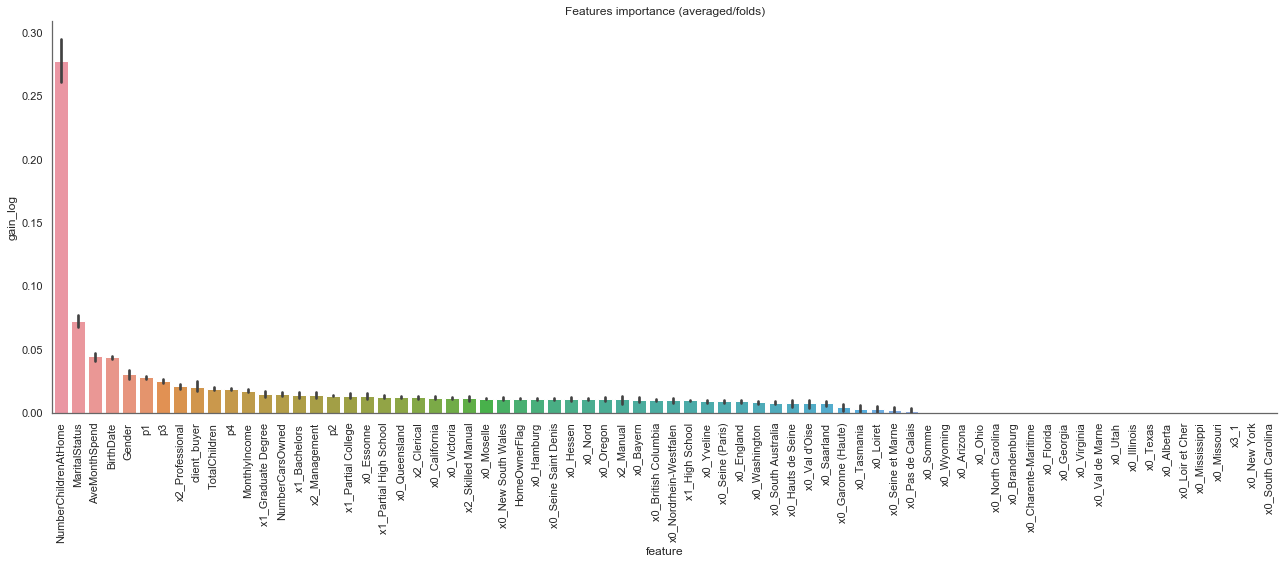

In [54]:
# mapping and spliting train and test data
X = train.drop('BikeBuyer', axis=1)
y = train['BikeBuyer']

features = [c for c in train.columns if c not in ['BikeBuyer']]
target = train['BikeBuyer']

# Split data with kfold
folds = StratifiedKFold(n_splits=5, shuffle=False, random_state=12)

# Make importance dataframe
importances = pd.DataFrame()
oof_preds = np.zeros(X.shape[0])
sub_preds = np.zeros(test.shape[0])

for n_fold, (trn_idx, val_idx) in enumerate(folds.split(X, y)):
    print("Fold {}".format(n_fold))
    X_train, y_train = X[features].iloc[trn_idx], y.iloc[trn_idx]
    X_valid, y_valid = X[features].iloc[val_idx], y.iloc[val_idx]
    
    # XGBoost Regressor estimator
    xgb_model = xgb.XGBClassifier(learning_rate=0.01, max_depth=5, subsample = .9, colsample_bylevel = .9, colsample_bytree = .9, min_child_weight= .9, booster = 'gbtree', 
                                  n_estimators=9000, n_jobs=-1, objective='binary:logistic', random_state=12, reg_lambda=1, seed=12, silent=None)
    # Fit
    xgb_model.fit(X_train, y_train, eval_set=[(X_train, y_train), (X_valid, y_valid)], verbose=1000, eval_metric='auc', early_stopping_rounds=300)
    
    # Feature importance
    imp_df = pd.DataFrame()
    imp_df['feature'] = features
    imp_df['gain'] = xgb_model.feature_importances_
    imp_df['fold'] = n_fold + 1
    importances = pd.concat([importances, imp_df], axis=0, sort=False)
    
    oof_preds[val_idx] = xgb_model.predict(X_valid, ntree_limit=xgb_model.best_ntree_limit)
    test_preds = xgb_model.predict(test[features], ntree_limit=xgb_model.best_ntree_limit)
    sub_preds += test_preds / folds.n_splits

print("Average CV score: {:<8.5f}".format(roc_auc_score(y, oof_preds)))

importances['gain_log'] = importances['gain']
mean_gain = importances[['gain', 'feature']].groupby('feature').mean()
importances['mean_gain'] = importances['feature'].map(mean_gain['gain'])

# ploting feature importance
fig, ax = plt.subplots(figsize=(18, 8))
ax = sns.barplot(x="feature", y="gain_log", data=importances.sort_values('mean_gain', ascending=False))
format_spines(ax, right_border=False)
ax.tick_params(axis='x', labelrotation=90)
ax.set_title('Features importance (averaged/folds)')
plt.tight_layout()

# Catboost

Fold 0
0:	test: 0.8097205	best: 0.8097205 (0)	total: 42.9ms	remaining: 6m 25s
1000:	test: 0.8659874	best: 0.8659975 (999)	total: 49.5s	remaining: 6m 35s
2000:	test: 0.8683279	best: 0.8683381 (1991)	total: 1m 51s	remaining: 6m 31s
3000:	test: 0.8686560	best: 0.8687963 (2737)	total: 2m 49s	remaining: 5m 38s
Stopped by overfitting detector  (300 iterations wait)

bestTest = 0.8687963472
bestIteration = 2737

Shrink model to first 2738 iterations.
Fold 1
0:	test: 0.8214142	best: 0.8214142 (0)	total: 67.8ms	remaining: 10m 9s
1000:	test: 0.8634199	best: 0.8634555 (999)	total: 47.2s	remaining: 6m 17s
Stopped by overfitting detector  (300 iterations wait)

bestTest = 0.8636485246
bestIteration = 1060

Shrink model to first 1061 iterations.
Fold 2
0:	test: 0.8297909	best: 0.8297909 (0)	total: 51.5ms	remaining: 7m 43s
1000:	test: 0.8697410	best: 0.8697647 (991)	total: 46.4s	remaining: 6m 10s
Stopped by overfitting detector  (300 iterations wait)

bestTest = 0.8711464673
bestIteration = 1510

Shr

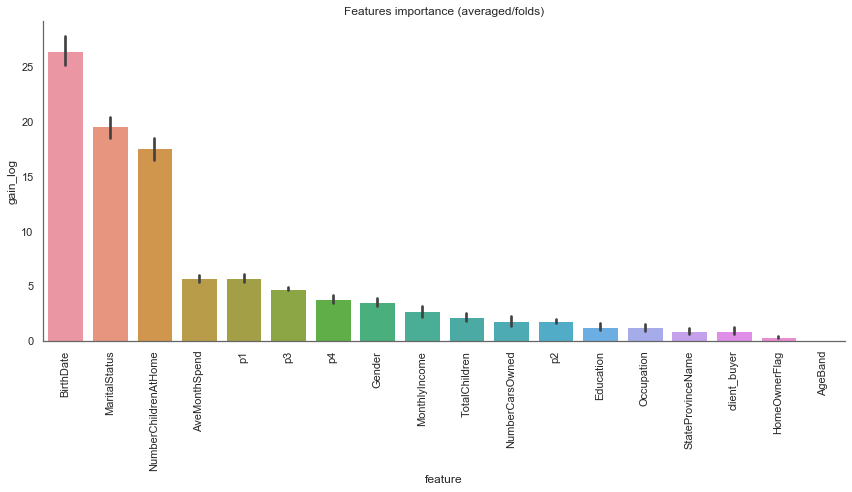

In [57]:
# mapping and spliting train and test data
X = train_cat.drop('BikeBuyer', axis=1)
y = train_cat['BikeBuyer']

cat_column = [0,1,2,3,4,5,6,7,8,9,10]

features = [c for c in train_cat.columns if c not in ['BikeBuyer']]
target = train_cat['BikeBuyer']

# Split data with kfold
folds = StratifiedKFold(n_splits=5, shuffle=False, random_state=12)

# Make importance dataframe
importances = pd.DataFrame()
oof_preds = np.zeros(X.shape[0])
sub_preds = np.zeros(test.shape[0])

for n_fold, (trn_idx, val_idx) in enumerate(folds.split(X, y)):
    print("Fold {}".format(n_fold))
    X_train, y_train = X[features].iloc[trn_idx], y.iloc[trn_idx]
    X_valid, y_valid = X[features].iloc[val_idx], y.iloc[val_idx]
    
    # XGBoost Regressor estimator
    ctb_model = CatBoostClassifier(iterations=9000, depth=6, learning_rate=0.01, custom_metric = 'Accuracy', eval_metric = 'AUC', loss_function="Logloss", random_seed=12)
    # Fit
    ctb_model.fit(X_train, y_train, eval_set=[(X_valid, y_valid)], verbose=1000, early_stopping_rounds=300, cat_features = cat_column)
    
    # Feature importance
    imp_df = pd.DataFrame()
    imp_df['feature'] = features
    imp_df['gain'] = ctb_model.get_feature_importance()
    imp_df['fold'] = n_fold + 1
    importances = pd.concat([importances, imp_df], axis=0, sort=False)
    
    oof_preds[val_idx] = ctb_model.predict(X_valid)
    test_preds = ctb_model.predict(test[features])
    sub_preds += test_preds / folds.n_splits

print("Average CV score: {:<8.5f}".format(roc_auc_score(y, oof_preds)))

importances['gain_log'] = importances['gain']
mean_gain = importances[['gain', 'feature']].groupby('feature').mean()
importances['mean_gain'] = importances['feature'].map(mean_gain['gain'])

# ploting feature importance
fig, ax = plt.subplots(figsize=(12, 7))
ax = sns.barplot(x="feature", y="gain_log", data=importances.sort_values('mean_gain', ascending=False))
format_spines(ax, right_border=False)
ax.tick_params(axis='x', labelrotation=90)
ax.set_title('Features importance (averaged/folds)')
plt.tight_layout()

In [118]:
frame = pd.read_csv('Desktop/DS ToolKit/DataSet/test_technidus_clf.csv')
predictions = frame[['CustomerID']]
predictions['BikeBuyer'] = (np.round(lgb_clf.predict(test, num_iteration=lgb_clf.best_iteration)))
predictions.to_csv("predictions.csv", index=False)

In [119]:
predictions.head()

,CustomerID,BikeBuyer
0,28611,0.0
1,24635,0.0
2,28178,0.0
3,24991,1.0
4,24113,0.0
